In [1]:
# Google Colabでの設定
google_colab = True

if google_colab:
    from google.colab import drive
    from google.colab import userdata

    drive.mount("/content/drive")

    # ディレクトリ移動
    %cd /content/drive/MyDrive/Python/kaggle_map/src/ettin-encoder-1b_exp004

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Python/kaggle_map/src/ettin-encoder-1b_exp004


In [2]:
import os
import gc
import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch
import wandb
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [3]:
class CFG:
    """実験設定管理クラス"""

    # ============== 実験情報 =============
    comp_name = "kaggle_map"
    exp_name = "ettin-encoder-1b_exp004"
    model_name = "jhu-clsp/ettin-encoder-1b"

    # ============== ファイルパス設定 =============
    comp_dir_path = "../../kaggle/input/"
    comp_dataset_path = f"{comp_dir_path}/map-charting-student-math-misunderstandings/"
    output_dir_path = "output/"
    log_dir_path = "logs/"

    # ============== モデル設定 =============
    max_len = 256

    num_train_epochs = 10
    per_device_train_batch_size = 32
    gradient_accumulation_steps = 1
    per_device_eval_batch_size = 64
    optim_type = "adamw_torch"
    learning_rate = 5e-5
    lr_scheduler_type = "cosine"
    warmup_steps = 50
    weight_decay = 0.01

    # ============== その他設定 =============
    seed = 42
    device = torch.device("cuda")

In [4]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.output_dir_path, cfg.log_dir_path]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg):
    set_seed(cfg.seed)
    make_dirs(cfg)

# LLMの学習

## データの読み込み

In [5]:
def add_folds_by_qid_cat_misc(df, n_splits=5, random_state=42, fallback="pair"):
    s_qid  = df["QuestionId"].astype(str).fillna("NA")
    s_cat  = df["Category"].astype(str).fillna("NA")
    s_misc = df["Misconception"].astype(str).fillna("NA")

    y_triple = s_qid + "|" + s_cat + "|" + s_misc
    y_pair   = s_cat + "|" + s_misc

    cnt = y_triple.value_counts()
    if (cnt < n_splits).any():
        if fallback == "pair":
            rare = y_triple.map(cnt) < n_splits
            y = np.where(rare, y_pair, y_triple)
        elif fallback == "category":
            rare = y_triple.map(cnt) < n_splits
            y = np.where(rare, s_cat, y_triple)
        elif fallback == "none":
            y = y_triple
        else:
            raise ValueError("fallback は 'pair' / 'category' / 'none' のいずれかにしてください。")
    else:
        y = y_triple

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    folds = np.full(len(df), -1, dtype=int)
    for fold, (_, val_idx) in enumerate(skf.split(np.zeros(len(df)), y)):
        folds[val_idx] = fold

    out = df.copy()
    out["fold"] = folds
    return out

In [6]:
# データ読み込み
train = pd.read_csv(f"{CFG.comp_dataset_path}/train.csv")
train = add_folds_by_qid_cat_misc(train, n_splits=5, random_state=42, fallback="pair")

train.Misconception = train.Misconception.fillna("NA")
train["target"] = train.Category + ":" + train.Misconception

# ラベルエンコード
le = LabelEncoder()
train["label"] = le.fit_transform(train["target"])

n_classes = len(le.classes_)
print(f"訓練データの形状: {train.shape} - {n_classes}個のターゲットクラス")
train.head(3)

訓練データの形状: (36696, 10) - 65個のターゲットクラス


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,fold,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,1,True_Correct:NA,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,4,True_Correct:NA,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,2,True_Neither:NA,64


## 特徴量エンジニアリング

In [7]:
# 正解ラベルの作成
idx = train.apply(lambda row: row.Category.split("_")[0], axis=1) == "True"
correct = train.loc[idx].copy()
correct["c"] = correct.groupby(["QuestionId", "MC_Answer"]).MC_Answer.transform("count")
correct = correct.sort_values("c", ascending=False)
correct = correct.drop_duplicates(["QuestionId"])
correct = correct[["QuestionId", "MC_Answer"]]
correct["is_correct"] = 1

# 正解ラベルを訓練データにマージ
train = train.merge(correct, on=["QuestionId", "MC_Answer"], how="left")
train.is_correct = train.is_correct.fillna(0)

# # 問題別の選択肢を抽出してカンマ区切りの文字列として追加
# question_choices = train.groupby("QuestionId")["Misconception"].apply(lambda x: sorted(x.unique())).reset_index()
# question_choices.columns = ["QuestionId", "choices_list"]
# question_choices["choices"] = question_choices["choices_list"].apply(lambda x: ", ".join(x))
# train = train.merge(question_choices[["QuestionId", "choices"]], on="QuestionId", how="left")

## データの前処理

In [8]:
# tokenizerの読み込み
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

In [9]:
# 学習データのtokenizer処理
def format_input(row):
    x = "Yes"
    if not row["is_correct"]:
        x = "No"
    return (
        f"Question: {row['QuestionText']}\n"
        # f"Choices: {row['choices']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"Correct: {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train["text"] = train.apply(format_input, axis=1)
print("LLMへのプロンプト例:")
print()
print(train.text.values[0])

LLMへのプロンプト例:

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
Correct: Yes
Student Explanation: 0ne third is equal to tree nineth


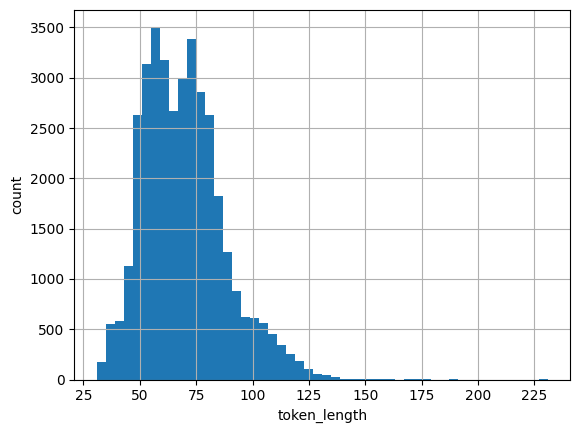

256トークンを超える訓練サンプルが0個あります


array([ 31,  31,  31, ..., 178, 187, 231])

In [10]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]

# トークン長の分布を可視化
plt.hist(lengths, bins=50)
plt.xlabel("token_length")
plt.ylabel("count")
plt.grid(True)
plt.show()

# max_lenを超えるサンプル数を確認
L = (np.array(lengths) > CFG.max_len).sum()
print(f"{CFG.max_len}トークンを超える訓練サンプルが{L}個あります")
np.sort(lengths)

In [11]:
# 訓練データと検証データに分割
train_df = train[train.fold != 0]
val_df = train[train.fold == 0]

# Hugging Faceデータセットに変換
COLS = ["text", "label"]
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

In [12]:
# トークナイズ関数
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# PyTorch用のフォーマットを設定
columns = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=columns)
val_ds.set_format(type="torch", columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

## 学習設定

In [13]:
# wandbのログイン
wandb.login(key=userdata.get("WANDB_API_KEY"))
wandb.init(project=CFG.comp_name, name=CFG.exp_name)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tomokazu_rikioka (tomokazu_rikioka_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:
# モデルの読み込み
model = AutoModelForSequenceClassification.from_pretrained(
    CFG.model_name,
    num_labels=n_classes,
    reference_compile=False,
)
# hdim = model.config.hidden_size
# model.score = torch.nn.Sequential(
#     torch.nn.Dropout(0.1),
#     torch.nn.Linear(hdim, hdim // 2),
#     torch.nn.Dropout(0.1),
#     torch.nn.GELU(),
#     torch.nn.Linear(hdim // 2, 2),
# ).to(CFG.device)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at jhu-clsp/ettin-encoder-1b and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# 学習の設定
training_args = TrainingArguments(
    output_dir=CFG.output_dir_path,
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps",
    num_train_epochs=CFG.num_train_epochs,
    per_device_train_batch_size=CFG.per_device_train_batch_size,
    gradient_accumulation_steps=CFG.gradient_accumulation_steps,
    per_device_eval_batch_size=CFG.per_device_eval_batch_size,
    learning_rate=CFG.learning_rate,
    optim=CFG.optim_type,
    lr_scheduler_type=CFG.lr_scheduler_type,
    warmup_steps=CFG.warmup_steps,
    weight_decay=CFG.weight_decay,
    logging_dir=CFG.log_dir_path,
    logging_steps=50,
    save_steps=600,
    eval_steps=300,
    save_total_limit=1,
    metric_for_best_model="map@3",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="wandb",
    bf16=True,
    fp16=False,  # KaggleはT4なのでFP16で推論
)

In [16]:
# カスタムメトリック
def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    top3 = np.argsort(-probs, axis=1)[:, :3]  # トップ3の予測
    match = top3 == labels[:, None]

    # MAP@3を計算
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

## モデルの学習

In [17]:
# トレーナーの設定
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    compute_metrics=compute_map3,
)
# hdim = model.config.hidden_size
# model.score = torch.nn.Sequential(
#     torch.nn.Dropout(0.1),
#     torch.nn.Linear(hdim, hdim // 2),
#     torch.nn.Dropout(0.1),
#     torch.nn.GELU(),
#     torch.nn.Linear(hdim // 2, 2),
# ).bfloat16().to(CFG.device)

# モデルの学習
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Step,Training Loss,Validation Loss,Map@3
300,0.529300,0.558343,0.892984
600,0.502100,0.425583,0.920186
900,0.434100,0.440877,0.911717
1200,0.335500,0.427234,0.923638
1500,0.345500,0.374369,0.931789
1800,0.390100,0.352258,0.931335
2100,0.248000,0.404160,0.930518
2400,0.249800,0.391061,0.932879
2700,0.266200,0.373513,0.932334
3000,0.143900,0.472773,0.933311


TrainOutput(global_step=9180, training_loss=0.15338615996921373, metrics={'train_runtime': 5536.3045, 'train_samples_per_second': 53.025, 'train_steps_per_second': 1.658, 'total_flos': 4.243590631456973e+17, 'train_loss': 0.15338615996921373, 'epoch': 10.0})

## モデルの保存

In [18]:
trainer.save_model(f"{CFG.output_dir_path}/model")
tokenizer.save_pretrained(f"{CFG.output_dir_path}/tokenizer")

('output//tokenizer/tokenizer_config.json',
 'output//tokenizer/special_tokens_map.json',
 'output//tokenizer/tokenizer.json')

In [19]:
# WandBのセッションを終了
with wandb.init():
    wandb.finish()

eval/loss,▃▂▂▂▁▁▁▁▁▂▁▂▃▂▃▄▄▄▅▆▅▆▇▆▇█████
eval/map@3,▁▅▄▆▇▇▇▇▇▇██▇███▇██▇██████████
eval/runtime,▁▁▃▃█▄▅▇▃▃▃▃▃▃▂▄▃▃▄▃▃▃▃▃▄▃▅▅▃▃
eval/samples_per_second,██▆▆▁▅▄▂▆▆▆▆▆▆▇▅▆▆▅▆▆▆▆▆▅▆▄▄▆▆
eval/steps_per_second,██▆▆▁▅▄▂▆▆▆▆▆▆▇▅▆▆▆▆▆▆▆▆▅▆▄▄▆▆
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
train/grad_norm,█▆▄▄▅▃▃▄▃▄▃▄▃▄▆▃▃▁▁▂▂▂▁▁▁▁▂▁▁▃▁▁▁▁▂▂▁▁▁▁
train/learning_rate,█████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train/loss,█▇▇▇▆▆▆▅▅▅▃▄▄▄▃▃▃▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,1.25315


In [20]:
# キャッシュ削除
del model, tokenizer, trainer
gc.collect()
torch.cuda.empty_cache()

# 結果分析

In [21]:
# 学習済みモデルの読み込み
model_path = f"{CFG.output_dir_path}/model"
tokenizer_path = f"{CFG.output_dir_path}/tokenizer"

inference_model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=n_classes,
    reference_compile=False,
)
# hdim = inference_model.config.hidden_size
# inference_model.score = torch.nn.Sequential(
#     torch.nn.Dropout(0.1),
#     torch.nn.Linear(hdim, hdim // 2),
#     torch.nn.Dropout(0.1),
#     torch.nn.GELU(),
#     torch.nn.Linear(hdim // 2, 2),
# ).bfloat16().to(CFG.device)
inference_tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# 推論用のインスタンスを作成
inference_trainer = Trainer(
    model=inference_model,
    processing_class=inference_tokenizer
)

# 検証データの推論実行
inference_model.eval()
start_time = time.time()

val_predictions = inference_trainer.predict(val_ds)
logits = val_predictions.predictions
val_labels = val_predictions.label_ids

# 推論時間を計算
inference_time = time.time() - start_time
print(f"推論時間: {inference_time:.2f}秒")
print(f"サンプル数: {len(val_labels)}個")
print(f"1サンプルあたりの推論時間: {inference_time/len(val_labels)*1000:.2f}ms")

# 確率値に変換
val_probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

# Top-1精度の計算
val_pred_labels = np.argmax(logits, axis=1)
accuracy = (val_pred_labels == val_labels).mean()
print(f"\nTop-1精度: {accuracy:.4f}")

# MAP@3スコアの計算
map3_score = compute_map3((logits, val_labels))["map@3"]
print(f"MAP@3スコア: {map3_score:.4f}")

推論時間: 44.39秒
サンプル数: 7340個
1サンプルあたりの推論時間: 6.05ms

Top-1精度: 0.8838
MAP@3スコア: 0.9372


## 項目別の結果分析

In [22]:
# Top-3予測の取得
top3_indices = np.argsort(-val_probs, axis=1)[:, :3]
top3_probs = np.take_along_axis(val_probs, top3_indices, axis=1)

# Top-1予測の取得
max_probs = val_probs.max(axis=1)

In [23]:
# 検証データに必要な情報を追加
val_df_analysis = val_df.copy()
val_df_analysis["pred_label"] = val_pred_labels
val_df_analysis["actual_label"] = val_labels
val_df_analysis["confidence"] = max_probs
val_df_analysis["is_correct"] = (val_pred_labels == val_labels)

# Top-3予測の情報を追加
for i in range(3):
    val_df_analysis[f"top{i+1}_label"] = top3_indices[:, i]
    val_df_analysis[f"top{i+1}_prob"] = top3_probs[:, i]
    val_df_analysis[f"top{i+1}_name"] = [le.inverse_transform([x])[0] for x in top3_indices[:, i]]

# Top-3に正解が含まれているか
val_df_analysis["is_in_top3"] = [label in top3_indices[i] for i, label in enumerate(val_labels)]

# MAP@3スコアを各サンプルごとに計算
def calculate_map3_per_sample(row):
    if row["actual_label"] == row["top1_label"]:
        return 1.0
    elif row["actual_label"] == row["top2_label"]:
        return 1.0 / 2
    elif row["actual_label"] == row["top3_label"]:
        return 1.0 / 3
    else:
        return 0.0

val_df_analysis["map3_score"] = val_df_analysis.apply(calculate_map3_per_sample, axis=1)

# CategoryとMisconceptionを分離
val_df_analysis["actual_category"] = val_df_analysis["target"].apply(lambda x: x.split(":")[0])
val_df_analysis["actual_misconception"] = val_df_analysis["target"].apply(lambda x: x.split(":")[1])
val_df_analysis["pred_category"] = val_df_analysis["top1_name"].apply(lambda x: x.split(":")[0])
val_df_analysis["pred_misconception"] = val_df_analysis["top1_name"].apply(lambda x: x.split(":")[1])

### Questionごとの予測確率分布

In [24]:
question_stats = val_df_analysis.groupby("QuestionId").agg({
    "map3_score": "mean",
    "is_correct": "mean",
    "is_in_top3": "mean",
    "confidence": "mean",
    "QuestionText": "first",
    "label": "count"
}).rename(columns={
    "map3_score": "MAP@3",
    "is_correct": "Top1_Accuracy",
    "is_in_top3": "Top3_Accuracy",
    "confidence": "Avg_Confidence",
    "label": "Sample_Count"
}).sort_values("MAP@3", ascending=False)

# 結果の表示
question_stats = question_stats.reset_index()
question_stats

,QuestionId,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,QuestionText,Sample_Count
0,31777,0.969454,0.939502,1.000000,0.989697,A box contains \( 120 \) counters. The counter...,562
1,32829,0.960170,0.925754,0.995360,0.988983,\( 2 y=24 \) What is the value of \( y \) ?,431
2,31772,0.952846,0.910494,0.996914,0.964367,What fraction of the shape is not shaded? Give...,972
3,33471,0.950917,0.915858,0.990291,0.989812,A bag contains \( 24 \) yellow and green balls...,309
4,32833,0.943371,0.888889,0.998390,0.973002,Calculate \( \frac{2}{3} \times 5 \),621
5,89443,0.941626,0.896890,0.990180,0.975723,What number belongs in the box?\n\(\n(-8)-(-5)...,611
6,104665,0.938272,0.888889,0.992593,0.974646,It takes \( 3 \) people a total of \( 192 \) h...,135
7,76870,0.935302,0.873418,1.000000,0.986851,This is part of a regular polygon. How many si...,237
8,33472,0.932440,0.869643,0.996429,0.969607,\( \frac{1}{3}+\frac{2}{5}= \),560
9,109465,0.930159,0.861905,1.000000,0.972374,The probability of an event occurring is \( 0....,210


### Categoryごとの予測確率分布

In [25]:
category_stats = val_df_analysis.groupby("actual_category").agg({
    "map3_score": "mean",
    "is_correct": "mean",
    "is_in_top3": "mean",
    "confidence": "mean",
    "label": "count"
}).rename(columns={
    "map3_score": "MAP@3",
    "is_correct": "Top1_Accuracy",
    "is_in_top3": "Top3_Accuracy",
    "confidence": "Avg_Confidence",
    "label": "Sample_Count"
}).sort_values("MAP@3", ascending=False)

# 結果の表示
category_stats = category_stats.reset_index()
category_stats

,actual_category,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,Sample_Count
0,True_Correct,0.973302,0.949307,0.997634,0.986623,2959
1,False_Misconception,0.954129,0.924459,0.987850,0.981418,1893
2,False_Neither,0.905581,0.816514,0.996942,0.957095,1308
3,True_Neither,0.870810,0.744782,1.000000,0.957686,1054
4,False_Correct,0.794574,0.697674,0.906977,0.924068,43
5,True_Misconception,0.682731,0.542169,0.879518,0.949573,83


### Misconceptionごとの予測確率分布

In [26]:
misconception_stats = val_df_analysis.groupby("actual_misconception").agg({
    "map3_score": "mean",
    "is_correct": "mean",
    "is_in_top3": "mean",
    "confidence": "mean",
    "label": "count"
}).rename(columns={
    "map3_score": "MAP@3",
    "is_correct": "Top1_Accuracy",
    "is_in_top3": "Top3_Accuracy",
    "confidence": "Avg_Confidence",
    "label": "Sample_Count"
}).sort_values("MAP@3", ascending=False)

# 結果の表示
misconception_stats = misconception_stats.reset_index()
display(misconception_stats.head())
display(misconception_stats.tail())

,actual_misconception,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,Sample_Count
0,Wrong_Fraction,1.0,1.0,1.0,0.996528,55
1,Interior,1.0,1.0,1.0,0.995636,10
2,Inverse_operation,1.0,1.0,1.0,0.949041,4
3,Ignores_zeroes,1.0,1.0,1.0,0.990503,4
4,Wrong_Operation,1.0,1.0,1.0,0.945295,1


,actual_misconception,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,Sample_Count
31,Base_rate,0.750000,0.666667,0.833333,0.920996,6
32,Firstterm,0.651515,0.545455,0.772727,0.877752,22
33,Longer_is_bigger,0.600000,0.600000,0.600000,0.810538,5
34,Incorrect_equivalent_fraction_addition,0.500000,0.500000,0.500000,0.989874,2
35,Shorter_is_bigger,0.208333,0.000000,0.500000,0.989033,4


### ラベル（Category:Misconception）ごとの予測確率分布

In [27]:
label_level_stats = val_df_analysis.groupby("target").agg({
    "map3_score": "mean",
    "is_correct": "mean",
    "is_in_top3": "mean",
    "confidence": "mean",
    "top1_prob": "mean",
    "top2_prob": "mean",
    "top3_prob": "mean",
    "label": "count"
}).rename(columns={
    "map3_score": "MAP@3",
    "is_correct": "Top1_Accuracy",
    "is_in_top3": "Top3_Accuracy",
    "confidence": "Avg_Confidence",
    "top1_prob": "Avg_Top1_Prob",
    "top2_prob": "Avg_Top2_Prob",
    "top3_prob": "Avg_Top3_Prob",
    "label": "Sample_Count"
}).sort_values('MAP@3', ascending=False)

# 結果を表示
label_level_stats = label_level_stats.reset_index()
display(label_level_stats.head())
display(label_level_stats.tail())

,target,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,Avg_Top1_Prob,Avg_Top2_Prob,Avg_Top3_Prob,Sample_Count
0,False_Misconception:Inverse_operation,1.0,1.0,1.0,0.949041,0.949041,0.034665,0.015515,4
1,False_Misconception:Interior,1.0,1.0,1.0,0.995636,0.995636,0.004300,0.000057,10
2,False_Misconception:Incorrect_equivalent_fract...,1.0,1.0,1.0,0.993525,0.993525,0.003473,0.000775,1
3,False_Misconception:Ignores_zeroes,1.0,1.0,1.0,0.990503,0.990503,0.007986,0.001481,4
4,False_Misconception:Wrong_Fraction,1.0,1.0,1.0,0.996528,0.996528,0.002767,0.000574,55


,target,MAP@3,Top1_Accuracy,Top3_Accuracy,Avg_Confidence,Avg_Top1_Prob,Avg_Top2_Prob,Avg_Top3_Prob,Sample_Count
55,True_Misconception:Adding_across,0.0,0.0,0.0,0.999867,0.999867,0.000109,0.000013,1
56,True_Misconception:Base_rate,0.0,0.0,0.0,0.646491,0.646491,0.346042,0.006747,1
57,True_Misconception:Incorrect_equivalent_fracti...,0.0,0.0,0.0,0.986224,0.986224,0.003557,0.002027,1
58,True_Misconception:Subtraction,0.0,0.0,0.0,0.931910,0.931910,0.052575,0.008319,1
59,True_Misconception:Whole_numbers_larger,0.0,0.0,0.0,0.998244,0.998244,0.001501,0.000036,1


In [28]:
# CSVで保存
question_stats.to_csv(f"{CFG.output_dir_path}/question_statistics.csv")
category_stats.to_csv(f"{CFG.output_dir_path}/category_statistics.csv")
misconception_stats.to_csv(f"{CFG.output_dir_path}/misconception_statistics.csv")
label_level_stats.to_csv(f"{CFG.output_dir_path}/label_level_statistics.csv")

In [29]:
# 検証データの全レコードに予測結果を付与したデータフレームを保存
val_df_with_predictions = val_df_analysis[[
    "row_id", "QuestionId", "QuestionText", "MC_Answer", "StudentExplanation",
    "Category", "Misconception", "target", "label", "actual_label",
    "pred_label", "confidence", "is_correct", "is_in_top3", "map3_score",
    "top1_label", "top1_prob", "top1_name",
    "top2_label", "top2_prob", "top2_name",
    "top3_label", "top3_prob", "top3_name",
    "actual_category", "actual_misconception",
    "pred_category", "pred_misconception"
]]

val_df_with_predictions.to_csv(f"{CFG.output_dir_path}/val_predictions_full.csv", index=False)

## 誤分類サンプルの分析

### Top-1で誤分類したサンプル

In [30]:
# 誤分類サンプルの特定
misclassified_mask = (val_pred_labels != val_labels)
misclassified_indices = np.where(misclassified_mask)[0]

print(f"誤分類サンプル数: {len(misclassified_indices)} / {len(val_labels)} ({len(misclassified_indices)/len(val_labels)*100:.1f}%)")

# 確信度の低いサンプルトップ10を表示
low_confidence_indices = np.argsort(max_probs)[:10]
print(f"\n=== 確信度の低いサンプル（上位10件）===")

for i, idx in enumerate(low_confidence_indices):
    actual_label = val_labels[idx]
    pred_label = val_pred_labels[idx]
    confidence = max_probs[idx]
    is_correct = "正解" if actual_label == pred_label else "誤り"

    actual_name = le.inverse_transform([actual_label])[0]
    pred_name = le.inverse_transform([pred_label])[0]

    print(f"#{i+1:2d} 確信度={confidence:.3f} ({is_correct})")
    print(f"    実際: {actual_name}")
    print(f"    予測: {pred_name}")
    print(f"    Top-3予測: {[le.inverse_transform([x])[0] for x in top3_indices[idx]]}")
    print(f"    Top-3確率: {top3_probs[idx]}")
    print()

# 誤分類の中で確信度の高いサンプルを表示（モデルが自信を持って間違えたケース）
if len(misclassified_indices) > 0:
    misclassified_confidences = max_probs[misclassified_indices]
    high_confidence_wrong_indices = misclassified_indices[np.argsort(-misclassified_confidences)[:10]]

    print(f"=== 高確信度で誤分類したサンプル（上位10件）===")
    for i, idx in enumerate(high_confidence_wrong_indices):
        actual_label = val_labels[idx]
        pred_label = val_pred_labels[idx]
        confidence = max_probs[idx]

        actual_name = le.inverse_transform([actual_label])[0]
        pred_name = le.inverse_transform([pred_label])[0]

        print(f"#{i+1} 確信度={confidence:.3f}")
        print(f"    実際: {actual_name}")
        print(f"    予測: {pred_name}")
        print(f"    Top-3予測: {[le.inverse_transform([x])[0] for x in top3_indices[idx]]}")
        print(f"    Top-3確率: {top3_probs[idx]}")
        print()

誤分類サンプル数: 853 / 7340 (11.6%)

=== 確信度の低いサンプル（上位10件）===
# 1 確信度=0.347 (誤り)
    実際: False_Neither:NA
    予測: False_Misconception:Ignores_zeroes
    Top-3予測: ['False_Misconception:Ignores_zeroes', 'False_Neither:NA', 'False_Correct:NA']
    Top-3確率: [0.34681737 0.34681737 0.30606526]

# 2 確信度=0.410 (正解)
    実際: False_Neither:NA
    予測: False_Neither:NA
    Top-3予測: ['False_Neither:NA', 'False_Correct:NA', 'False_Misconception:Whole_numbers_larger']
    Top-3確率: [0.4103025  0.36209068 0.20631304]

# 3 確信度=0.433 (正解)
    実際: False_Misconception:WNB
    予測: False_Misconception:WNB
    Top-3予測: ['False_Misconception:WNB', 'False_Neither:NA', 'False_Misconception:Irrelevant']
    Top-3確率: [0.43250698 0.29725742 0.26232874]

# 4 確信度=0.466 (正解)
    実際: False_Neither:NA
    予測: False_Neither:NA
    Top-3予測: ['False_Neither:NA', 'False_Misconception:Incomplete', 'False_Misconception:Wrong_Fraction']
    Top-3確率: [0.46575835 0.36273298 0.16096179]

# 5 確信度=0.472 (誤り)
    実際: True_Neither:NA
    予測:

### Top-3で誤分類したサンプル

In [31]:
# 誤分類サンプルの特定
misclassified_mask = [val_labels[i] not in top3_indices[i] for i in range(len(val_labels))]
misclassified_indices = np.where(misclassified_mask)[0]

print(f"誤分類サンプル数: {len(misclassified_indices)} / {len(val_labels)} "
      f"({len(misclassified_indices)/len(val_labels)*100:.1f}%)")

# 確信度の低いサンプルトップ10を表示
low_confidence_indices = np.argsort(max_probs)[:10]
print(f"\n=== 確信度の低いサンプル（上位10件）===")

for i, idx in enumerate(low_confidence_indices):
    actual_label = val_labels[idx]
    pred_label = val_pred_labels[idx]
    confidence = max_probs[idx]
    is_correct = "正解" if actual_label in top3_indices[idx] else "誤り"

    actual_name = le.inverse_transform([actual_label])[0]
    pred_name = le.inverse_transform([pred_label])[0]

    print(f"#{i+1:2d} 確信度={confidence:.3f} ({is_correct})")
    print(f"    実際: {actual_name}")
    print(f"    予測: {pred_name}")
    print(f"    Top-3予測: {[le.inverse_transform([x])[0] for x in top3_indices[idx]]}")
    print(f"    Top-3確率: {top3_probs[idx]}")
    print()

# 誤分類の中で確信度の高いサンプルを表示（モデルが自信を持って間違えたケース）
if len(misclassified_indices) > 0:
    misclassified_confidences = max_probs[misclassified_indices]
    high_confidence_wrong_indices = misclassified_indices[np.argsort(-misclassified_confidences)[:10]]

    print(f"=== 高確信度で誤分類したサンプル（上位10件）===")
    for i, idx in enumerate(high_confidence_wrong_indices):
        actual_label = val_labels[idx]
        pred_label = val_pred_labels[idx]
        confidence = max_probs[idx]

        actual_name = le.inverse_transform([actual_label])[0]
        pred_name = le.inverse_transform([pred_label])[0]

        print(f"#{i+1} 確信度={confidence:.3f}")
        print(f"    実際: {actual_name}")
        print(f"    予測: {pred_name}")
        print(f"    Top-3予測: {[le.inverse_transform([x])[0] for x in top3_indices[idx]]}")
        print(f"    Top-3確率: {top3_probs[idx]}")
        print()

誤分類サンプル数: 48 / 7340 (0.7%)

=== 確信度の低いサンプル（上位10件）===
# 1 確信度=0.347 (正解)
    実際: False_Neither:NA
    予測: False_Misconception:Ignores_zeroes
    Top-3予測: ['False_Misconception:Ignores_zeroes', 'False_Neither:NA', 'False_Correct:NA']
    Top-3確率: [0.34681737 0.34681737 0.30606526]

# 2 確信度=0.410 (正解)
    実際: False_Neither:NA
    予測: False_Neither:NA
    Top-3予測: ['False_Neither:NA', 'False_Correct:NA', 'False_Misconception:Whole_numbers_larger']
    Top-3確率: [0.4103025  0.36209068 0.20631304]

# 3 確信度=0.433 (正解)
    実際: False_Misconception:WNB
    予測: False_Misconception:WNB
    Top-3予測: ['False_Misconception:WNB', 'False_Neither:NA', 'False_Misconception:Irrelevant']
    Top-3確率: [0.43250698 0.29725742 0.26232874]

# 4 確信度=0.466 (正解)
    実際: False_Neither:NA
    予測: False_Neither:NA
    Top-3予測: ['False_Neither:NA', 'False_Misconception:Incomplete', 'False_Misconception:Wrong_Fraction']
    Top-3確率: [0.46575835 0.36273298 0.16096179]

# 5 確信度=0.472 (正解)
    実際: True_Neither:NA
    予測: T